In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tslearn as ts
import numpy as np

# 1. Import et nettoyage des données

In [2]:
house2_power_blk1 = pd.read_csv('data/house2_power_blk1_labels.zip', index_col='datetime').interpolate('linear')
house2_power_blk1.index = pd.to_datetime(house2_power_blk1.index)
house2_power_blk1 = house2_power_blk1.asfreq('s')
#house2_power_blk1 = house2_power_blk1.loc['2016-03-06 00:00:00':'2016-03-13 00:00:00']
#house2_power_blk1 = house2_power_blk1.resample('1min').nearest()
house2_power_blk1['hour'] = house2_power_blk1.index.hour
house2_power_blk1.head()

,mains,activity,hour
datetime,,,
2017-09-12 23:00:00,103.0,0,23
2017-09-12 23:00:01,101.0,0,23
2017-09-12 23:00:02,104.0,0,23
2017-09-12 23:00:03,104.0,0,23
2017-09-12 23:00:04,105.0,0,23


In [3]:
from sklearn.preprocessing import MinMaxScaler

house2_power_blk1['mains_scaled'] = MinMaxScaler().fit_transform(house2_power_blk1['mains'].values.reshape(-1,1))
house2_power_blk1['diff_scaled'] = MinMaxScaler().fit_transform(house2_power_blk1['mains'].diff(1).values.reshape(-1,1))
house2_power_blk1['hour_scaled'] = MinMaxScaler().fit_transform(house2_power_blk1['hour'].values.reshape(-1,1))
house2_power_blk1 = house2_power_blk1.dropna()

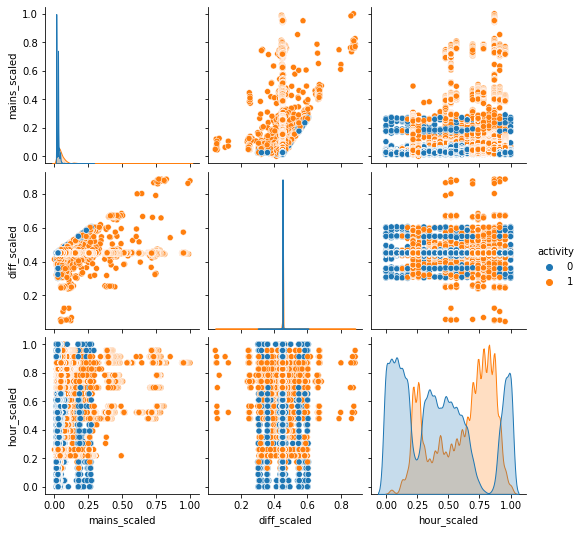

In [17]:
sns.pairplot(house2_power_blk1[['mains_scaled', 'diff_scaled', 'hour_scaled', 'activity']].loc['2017-09-12 23:00:00':'2017-09-27 23:00:00'], hue='activity');

In [4]:
def split_train_test_indexes(data, percentage=0.3):
    # tirage de jours aléatoires
    delta_time = data.index[-2] - data.index[0]
    nb_days = int(delta_time.days * percentage)
    random_dates = house2_power_blk1.index[0] + pd.to_timedelta(np.random.choice(delta_time.days, nb_days, replace=False), unit='day')

    data_freq = pd.Timedelta(house2_power_blk1.index.freq).seconds if house2_power_blk1.index.freq else 1
    # définition des indexes test, train
    test_indexes = pd.DatetimeIndex(np.array([pd.date_range(d, periods=24*60*60/data_freq, freq=house2_power_blk1.index.freq) for d in random_dates]).ravel())
    train_indexes = data.index[~np.isin(data.index, test_indexes)]

    return train_indexes, test_indexes

In [5]:
train_indexes, test_indexes = split_train_test_indexes(house2_power_blk1, 0.3)
X_train, X_test = house2_power_blk1.loc[train_indexes, ['mains_scaled', 'diff_scaled', 'hour_scaled']].values, house2_power_blk1.loc[test_indexes, ['mains_scaled', 'diff_scaled', 'hour_scaled']].values
y_train, y_test = house2_power_blk1.loc[train_indexes, 'activity'].values, house2_power_blk1.loc[test_indexes, 'activity'].values

# 2. Algorithmes généraux

In [6]:
from sklearn.metrics import fbeta_score, accuracy_score

def plot_scores_param(X_train, X_test, y_train, y_test, estimator, param_name, param_range, other_params={}):
    f2_score = []
    score = []
    for p in param_range:
        classifier = estimator(**{param_name:p}, **other_params)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)

        f2_score.append((fbeta_score(y_test, y_pred, average='macro', beta=0.5)))
        score.append(accuracy_score(y_test, y_pred))

    best_param = np.argmax(f2_score)

    plt.figure(figsize=(10, 6));
    plt.plot(param_range, score, label='score', color='grey', linestyle='dashed');
    plt.plot(param_range, f2_score, label='fb score');
    plt.scatter(param_range[best_param], f2_score[best_param], label='fb min', marker='x', s=100, color='red')
    plt.legend();
    plt.title('fb and score = f({})'.format(param_name));
    plt.show();

    print('Meilleur fb score={:.2f} obtenu pour {}={:.2f}'.format(f2_score[best_param], param_name, param_range[best_param]))

    classifier = estimator(**{param_name:param_range[best_param]})
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    sns.heatmap(pd.crosstab(y_test, y_pred, normalize=True), annot=True, fmt='.1%', cmap=sns.cm.rocket_r);
    plt.title('Resultats avec {}={:.2f}'.format(param_name, param_range[best_param]));
    plt.show();

    return param_name, param_range[best_param], f2_score[best_param]

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train.ravel())
y_pred = knn.predict(X_test)
print(fbeta_score(y_test, y_pred, average='macro', beta=0.5))
print(accuracy_score(y_test, y_pred))

0.7689425894510692
0.7710205610021786


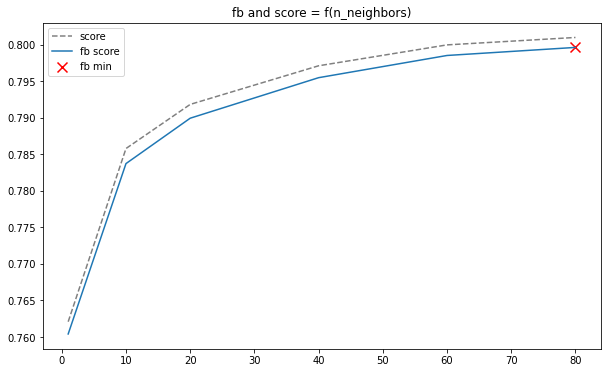

Meilleur fb score=0.80 obtenu pour n_neighbors=80.00


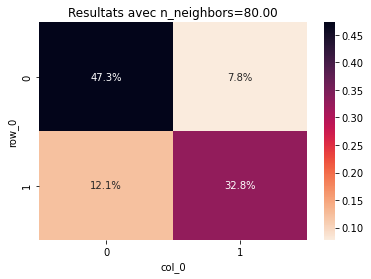

In [22]:
from sklearn.neighbors import KNeighborsClassifier

k_range = [1, 10, 20, 40, 60, 80]
plot_scores_param(X_train, X_test, y_train, y_test, KNeighborsClassifier, 'n_neighbors', k_range);


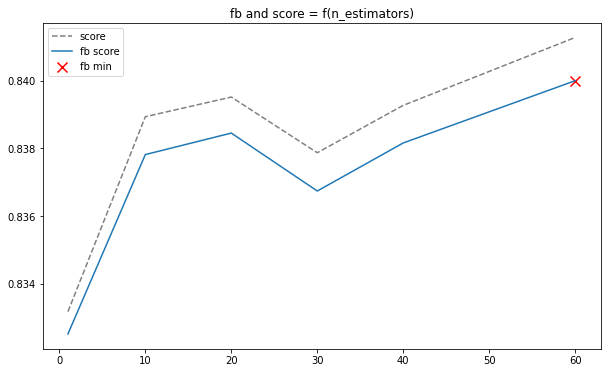

Meilleur fb score=0.84 obtenu pour n_estimators=60.00


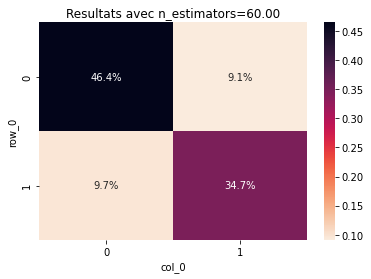

In [7]:
from sklearn.ensemble import RandomForestClassifier

n_range = [1, 10, 20, 30, 40, 60]
plot_scores_param(X_train, X_test, y_train, y_test, RandomForestClassifier, 'n_estimators', n_range, other_params={'n_jobs': -1, 'max_samples': 0.8, 'max_depth': 12});

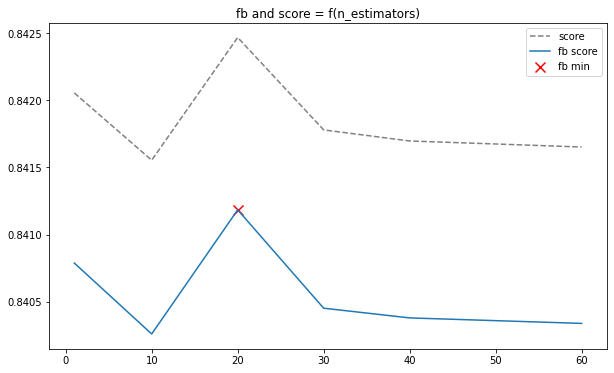

Meilleur fb score=0.84 obtenu pour n_estimators=20.00


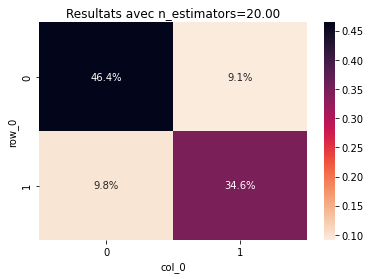

('n_estimators', 20, 0.8411843245028237)

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

n_range = [1, 10, 20, 30, 40, 60]
plot_scores_param(X_train, X_test, y_train, y_test, BaggingClassifier, 'n_estimators', n_range, other_params={'n_jobs': -1, 'max_samples': 0.8, 'base_estimator': DecisionTreeClassifier(max_depth=10)})